In [81]:
import pandas as pd
import requests
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
import time 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils.class_weight import compute_sample_weight
import seaborn as sb

In [82]:
def get_user_animelist(username: str, client_id: str):
    # Loads list of anime from MAL for a given user
    url = f'https://api.myanimelist.net/v2/users/{username}/animelist?limit=500'
    headers = {
        'X-MAL-CLIENT-ID': client_id
    }
    params = {
        'fields': 'id, title, list_status{score,status}, start_season{year}, mean, genres, popularity, media_type, rating, num_episodes, studios, num_list_users,favorites'
    }

    all_data = []
    next_page = url

    while next_page:
        response = requests.get(next_page, headers=headers, params=params if next_page == url else None)
        if response.status_code != 200:
            raise ValueError(f"Error with API request: {response.status_code} - {response.text}")

        data = response.json()
        all_data.extend(data['data'])
        next_page = data.get("paging", {}).get("next")

        print(f"Loaded {len(all_data)} anime...")

    return all_data

In [83]:
def to_dataframe(all_data):
    rows = []
    for item in all_data:
        anime = item['node']
        score = item.get('list_status', {}).get('score')
        status = item.get('list_status', {}).get('status')
        # num_episodes_watched = item.get('list_status', {}).get('num_episodes_watched')
        year = item.get('node', {}).get('start_season', {}).get('year')
        rows.append({
            "id": anime['id'],
            "title": anime['title'],
            "mean": anime.get('mean'),
            "genres": [g['name'] for g in anime.get('genres', [])],
            "studios": [s['name'] for s in anime.get('studios', [])],
            "rating": anime.get('rating'),
            "year": year,
            "type": anime.get('media_type'),
            "popularity": anime.get('popularity'),
            "score": score,
            "status": status,
            "members": anime['num_list_users'],
            "num_episodes": anime['num_episodes'],
        })
    
    df = pd.DataFrame(rows)
    df['studios'] = df['studios'].str.join(", ")
    df['genres'] = df['genres'].str.join(", ")

    return df

In [84]:
def comprehensive_evaluation(y_true, y_pred):
    """complex evaluation"""
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    accuracy_05 = np.mean(np.abs(y_true - y_pred) <= 0.5)
    accuracy_1 = np.mean(np.abs(y_true - y_pred) <= 1.0)
    accuracy_15 = np.mean(np.abs(y_true - y_pred) <= 1.5)
    
    score_metrics = {}
    for score in range(1, 11):
        mask = (y_true == score)
        if mask.sum() > 0:
            score_mae = mean_absolute_error(y_true[mask], y_pred[mask])
            score_metrics[f'MAE_score_{score}'] = score_mae
    
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    
    return {
        'MAE': mae,
        'MSE': mse, 
        'RMSE': rmse,
        'R2': r2,
        'Correlation': correlation,
        'Accuracy_±0.5': accuracy_05,
        'Accuracy_±1.0': accuracy_1,
        'Accuracy_±1.5': accuracy_15,
        **score_metrics
    }


In [85]:
def calculate_genre_affinity(df_train):
    """
    Considers
    - mean score
    - amount of watched (confidence)
    - Standard deviation (stability)
    """
    genre_cols = [col for col in df_train.columns if col.startswith('Genre_')]
    genre_affinity = {}
    
    overall_mean = df_train['score'].mean()
    
    for genre_col in genre_cols:
        genre_name = genre_col.replace('Genre_', '')
        mask = df_train[genre_col] == 1
        
        if mask.sum() >= 3:
            genre_scores = df_train[mask]['score']
            
            mean_score = genre_scores.mean()
            count = len(genre_scores)
            std = genre_scores.std()
            
            confidence = min(count / 10, 1.0)
            
            stability = 1 / (std + 1) if std > 0 else 1.0
            
            affinity = mean_score * confidence * stability
            genre_affinity[genre_name] = affinity
        else:
            genre_affinity[genre_name] = overall_mean * 0.5
    
    return genre_affinity

In [86]:
import configparser

config = configparser.ConfigParser()
config.read('../config.ini')
USER_NAME = config.get('USER','USER_NAME').strip()
CLIENT_ID = config.get('USER','CLIENT_ID').strip()

In [87]:
data = get_user_animelist(USER_NAME, CLIENT_ID)

Loaded 500 anime...
Loaded 1000 anime...
Loaded 1500 anime...
Loaded 2000 anime...
Loaded 2500 anime...
Loaded 3000 anime...
Loaded 3500 anime...
Loaded 4000 anime...
Loaded 4500 anime...
Loaded 5000 anime...
Loaded 5054 anime...


In [88]:
df = to_dataframe(data)

In [ ]:
df.tail(10)

In [ ]:
df["studios"].replace(to_replace="", value="Unknown", inplace=True)
df["genres"].replace(to_replace="", value="Unknown", inplace=True)
df = df.dropna(subset=['score'])

In [90]:
display(df["score"].value_counts().head(11))

score
0     1328
5      793
7      757
6      574
8      517
4      434
3      350
9      151
2      114
10      25
1       11
Name: count, dtype: int64

In [91]:
df.drop(columns=['title'], inplace=True)

In [92]:
df = df[df['score'] > 0].copy()
    
df['mean'] = df['mean'].fillna(df.groupby('type')['mean'].transform('median'))
    
categorical_cols = ['type', 'rating', 'status']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

In [93]:
df['year'] = df['year'].fillna(df['year'].mode()[0])
df['num_episodes'] = df['num_episodes'].fillna(df['num_episodes'].mode()[0])

In [94]:
df['popularity'] = df['popularity'].fillna(df['popularity'].median())

In [95]:
df['anime_age'] = 2025 - df['year']
df['anime_age'] = df['anime_age'].astype(int)
df.drop(columns=['year'], inplace=True)

In [96]:
df['log_members'] = np.log1p(df['members'])
df.drop(columns=['id', 'members'], inplace=True)

In [97]:
# Get dummy variables for each unique genre
genre_dummies = (
    df['genres']
    .str.split(', ', expand=True) 
    .stack()       
    .str.get_dummies()         
    .groupby(level=0)         
    .sum()                    
    .add_prefix('Genre_')  
)

df.drop(columns=['genres'], inplace=True)

In [98]:
df = pd.concat([df, genre_dummies], axis=1)

In [99]:
genre_columns = [col for col in df.columns if col.startswith('Genre_')]

genre_counts = df[genre_columns].sum().sort_values(ascending=False)
print(genre_counts)

Genre_Action         1480
Genre_Comedy         1336
Genre_Fantasy         996
Genre_School          918
Genre_Romance         871
                     ... 
Genre_Educational       6
Genre_Hentai            2
Genre_Boys Love         2
Genre_Erotica           2
Genre_Unknown           1
Length: 79, dtype: int64


In [100]:
type_dummies = pd.get_dummies(df['type'], prefix='Type')
df = pd.concat([df, type_dummies], axis=1)
df.drop(columns=['type'], inplace=True)

In [101]:
top_studios = df['studios'].value_counts().nlargest(10).index
print(top_studios)

Index(['J.C.Staff', 'A-1 Pictures', 'Madhouse', 'Studio Deen', 'Sunrise',
       'Production I.G', 'Bones', 'SILVER LINK.', 'Gonzo', 'Toei Animation'],
      dtype='object', name='studios')


In [102]:
df['studios'] = df['studios'].apply(lambda x: x if x in top_studios else 'Studios_Other')

In [103]:
studio_dummies = pd.get_dummies(df['studios'], prefix='Studios')
df = pd.concat([df, studio_dummies], axis=1)
df.drop(columns=['studios'], inplace=True)

In [104]:
rating_dummies = pd.get_dummies(df['rating'], prefix='Rating')
df = pd.concat([df, rating_dummies], axis=1)
df.drop(columns=['rating'], inplace=True)

In [105]:
status_dummies = pd.get_dummies(df['status'], prefix='Status')
df = pd.concat([df, status_dummies], axis=1)
df.drop(columns=['status'], inplace=True)

In [106]:
bool_cols = df.select_dtypes('bool').columns

df[bool_cols] = df[bool_cols].astype(int)

In [107]:
df.drop(columns=['Genre_Unknown'], inplace=True)

In [108]:
correlation = df['mean'].corr(df['score'])
print(correlation)

0.6883962470382563


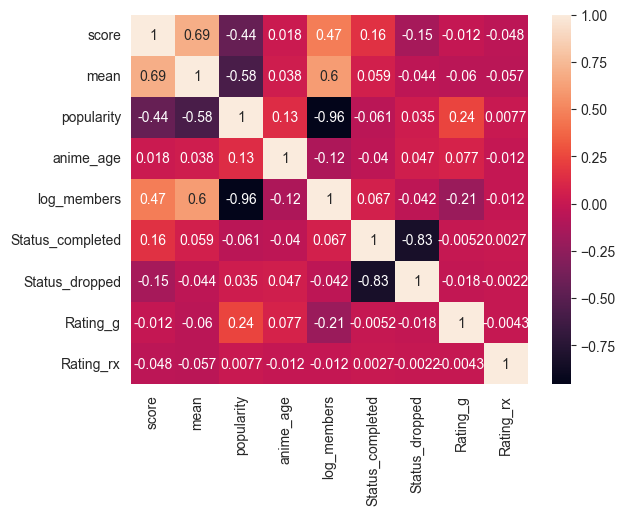

In [109]:
corr_cols = ['score', 'mean', 'popularity', 'anime_age', 
             'log_members', 
             'Status_completed', 'Status_dropped', 
             'Rating_g', 'Rating_rx']

corr_matrix = df[corr_cols].corr()
sb.heatmap(corr_matrix, annot=True)
plt.show()

In [110]:
corr_with_score = df.corr()['score']
high_corr_cols = corr_with_score[np.abs(corr_with_score) > 0.65].index
high_corr_cols = high_corr_cols.drop('score')
print(high_corr_cols)

Index(['mean'], dtype='object')


In [111]:
df.drop(columns=high_corr_cols, inplace=True)

In [112]:
df['num_episodes'] = np.log1p(df['num_episodes'])
df.drop(columns=['popularity'], inplace=True)

In [113]:
X = df.drop(columns=['score'])
y = df['score']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [115]:
genre_affinity = calculate_genre_affinity(X_train.join(y_train))

affinity_features_train = pd.DataFrame({
    f"affinity_{genre}": X_train[f"Genre_{genre}"] * affinity
    for genre, affinity in genre_affinity.items()
}, index=X_train.index)

affinity_features_test = pd.DataFrame({
    f"affinity_{genre}": X_test[f"Genre_{genre}"] * affinity
    for genre, affinity in genre_affinity.items()
}, index=X_test.index)

# Добавляем все affinity сразу
X_train = pd.concat([X_train, affinity_features_train], axis=1)
X_test = pd.concat([X_test, affinity_features_test], axis=1)

In [119]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2980 entries, 1535 to 71
Columns: 111 entries, num_episodes to affinity_Workplace
dtypes: float64(80), int32(31)
memory usage: 2.3 MB


In [117]:
X_train.head()

,num_episodes,anime_age,log_members,Genre_Action,Genre_Adult Cast,Genre_Adventure,Genre_Anthropomorphic,Genre_Avant Garde,Genre_Award Winning,Genre_Boys Love,...,affinity_Survival,affinity_Suspense,affinity_Team Sports,affinity_Time Travel,affinity_Urban Fantasy,affinity_Vampire,affinity_Video Game,affinity_Villainess,affinity_Visual Arts,affinity_Workplace
1535,3.258097,12,12.572849,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1654,0.693147,9,10.442959,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3618,1.945910,10,8.964696,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
774,2.564949,10,11.600378,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1411,2.564949,0,10.946570,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
X_train = X_train.drop(columns=[col for col in X_train.columns if col.startswith("Genre_")])
X_test = X_test.drop(columns=[col for col in X_test.columns if col.startswith("Genre_")])

In [120]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [121]:
# balancing
sample_weights = compute_sample_weight('balanced', y_train.astype(int))

In [122]:
model_weighted = RandomForestRegressor(n_estimators=300, min_samples_leaf=2, random_state=42 )
model_weighted.fit(X_train, y_train, sample_weight=sample_weights)

RandomForestRegressor(min_samples_leaf=2, n_estimators=300, random_state=42)

In [123]:
y_pred_weight = model_weighted.predict(X_test)

In [124]:
print("Weighted")
results = comprehensive_evaluation(y_test, y_pred_weight)
for metric, value in results.items():
    print(f"{metric}: {value:.3f}")

Weighted
MAE: 1.125
MSE: 1.971
RMSE: 1.404
R2: 0.394
Correlation: 0.632
Accuracy_±0.5: 0.286
Accuracy_±1.0: 0.523
Accuracy_±1.5: 0.700
MAE_score_1: 3.315
MAE_score_2: 1.997
MAE_score_3: 1.750
MAE_score_4: 1.057
MAE_score_5: 0.825
MAE_score_6: 0.868
MAE_score_7: 0.955
MAE_score_8: 1.380
MAE_score_9: 1.565
MAE_score_10: 1.437


In [ ]:
# importances = pd.Series(model_weighted.feature_importances_, index=X.columns)
# importances.nlargest(20).plot(kind='barh', figsize=(8,6))
# plt.title("Top-20 Feature Importances")
# plt.show()

In [125]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, sample_weight=sample_weights)
y_pred_cb = model.predict(X_test)


0:	learn: 2.8020786	test: 1.7875222	best: 1.7875222 (0)	total: 6.5ms	remaining: 6.49s
100:	learn: 1.3772697	test: 1.5403469	best: 1.5343411 (31)	total: 1.02s	remaining: 9.12s
200:	learn: 1.1559824	test: 1.4667172	best: 1.4667172 (200)	total: 2.04s	remaining: 8.11s
300:	learn: 1.0144849	test: 1.4266616	best: 1.4266616 (300)	total: 3s	remaining: 6.97s
400:	learn: 0.9301378	test: 1.4051876	best: 1.4050445 (398)	total: 4.02s	remaining: 6s
500:	learn: 0.8712727	test: 1.3947699	best: 1.3946057 (499)	total: 4.93s	remaining: 4.92s
600:	learn: 0.8220703	test: 1.3887467	best: 1.3887467 (600)	total: 6.03s	remaining: 4.01s
700:	learn: 0.7822126	test: 1.3818395	best: 1.3816942 (694)	total: 7.07s	remaining: 3.02s
800:	learn: 0.7456581	test: 1.3785648	best: 1.3784789 (799)	total: 8.04s	remaining: 2s
900:	learn: 0.7124860	test: 1.3748723	best: 1.3747950 (899)	total: 9.22s	remaining: 1.01s
999:	learn: 0.6829288	test: 1.3722756	best: 1.3721086 (976)	total: 10.1s	remaining: 0us

bestTest = 1.37210859
bes

In [126]:
print("Catboost")
results = comprehensive_evaluation(y_test, y_pred_cb)
for metric, value in results.items():
    print(f"{metric}: {value:.3f}")

Catboost
MAE: 1.074
MSE: 1.883
RMSE: 1.372
R2: 0.421
Correlation: 0.667
Accuracy_±0.5: 0.308
Accuracy_±1.0: 0.551
Accuracy_±1.5: 0.736
MAE_score_1: 3.319
MAE_score_2: 1.735
MAE_score_3: 1.470
MAE_score_4: 0.969
MAE_score_5: 0.916
MAE_score_6: 0.971
MAE_score_7: 0.943
MAE_score_8: 1.191
MAE_score_9: 1.315
MAE_score_10: 0.889


In [ ]:
# df.drop(columns=['log_members'], inplace=True)

In [ ]:
# importances = pd.Series(model_weighted.feature_importances_, index=X.columns)
# importances.nlargest(20).plot(kind='barh', figsize=(8,6))
# plt.title("Top-20 Feature Importances")
# plt.show()